In [1]:
import numpy as np
from meshplot import plot, subplot, interact
import igl
import scipy
import os
root_folder = os.getcwd()

In [2]:
from src.generate_mesh import triangular_lattice
from src.generate_mesh import create_mesh
from src.generate_mesh import linked_list_cell
from src.elastic_energy import elastic_energy
from src.MC_vertex_link import MCstep_vertex
from src.MC_vertex_link import MCstep_link

triangular_lattice = np.array( triangular_lattice(1.1, expansion_level =1 ) ) # returns a list with points on the Euclidean plane (2d space)
ver, TRI=create_mesh(triangular_lattice)
header,linklis,L=linked_list_cell(ver)
ev,et,te=igl.edge_topology(ver,TRI) #ev edges as pair of vertices, et triangle edge relation, te edge triangle relation, -1 for boundaries
gen=igl.adjacency_matrix(TRI)
neig=scipy.sparse.lil_matrix(gen) #lil more efficint sparse format

In [3]:
border=igl.is_border_vertex(ver,TRI)
ver_bulk=[]
for i in range(0,len(border)):
    if border[i]==False:
        ver_bulk.append(i)
        ver[i]=[ver[i][0],ver[i][1],0]
    else:
        ver[i]=[ver[i][0],ver[i][1],0]
ver[1]=[ver[1][0],ver[1][1],1]

In [22]:
plot(ver,TRI)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [16]:
k=1000
β=0.1
r=1.0
σ=0.1*r


normals_ver=igl.per_vertex_normals(ver, TRI, igl.PER_VERTEX_NORMALS_WEIGHTING_TYPE_AREA)
z=np.array([1/3,1/3,1/3])
z=z/np.linalg.norm(z)
normals_face=igl.per_face_normals(ver,TRI,z) #z normal given to degenerate faces(??)
area = igl.doublearea(ver, TRI) / 2.0
neigh=igl.adjacency_list(TRI)
ADJ,NI=igl.vertex_triangle_adjacency(TRI, len(ver))
    

H,c1,c2,A_v,SHO=Elastic_Local(ver,TRI,k,normals_ver,normals_face,area,neigh,ADJ,NI,et,te,border)
H/k

[-0.24970588  0.43250328 -0.4540107 ]
-1.0763756475930335
[0.49941177 0.         0.4540107 ]
1.076375647593034
[ 0.24970588 -0.43250328 -0.4540107 ]
-1.0763756475930335
[-0.49941177  0.          0.4540107 ]
1.076375647593034
[0.24970588 0.43250328 0.4540107 ]
1.076375647593034
[-0.24970588 -0.43250328  0.4540107 ]
1.076375647593034


0.835075728106523

In [13]:
pd1, pd2, f1, f2 = igl.principal_curvature(ver, TRI)
elastic_energy(ver,TRI,k)/k

9.149150404823713

In [14]:
c1[1],c2[1]

(1.5727391874180858, -0.524246395806028)

In [15]:
f1[1],f2[1]

(1.65289256198347, 1.6528925619834702)

#to check it updates correctly
for i in range(0,len(ev)):
    for j in range(0,len(ver)):
        if abs(SHO[0,0,i,j]-SHO2[0,0,i,j])>10e-10:
            print(SHO[0,0,i,j],SHO2[0,0,i,j]," ",i," ",j)
            print(SHO[:,:,i,j]," ",SHO2[:,:,i,j])

In [21]:
for z in range(0,10): 
    H_new=MCstep_vertexB(ver,TRI,header,linklis,L,σ,r,k,β,H,c1,c2,A_v,normals_face,ADJ,NI,neigh,et,ev,SHO,ver_bulk,border)
    H=H_new
    #MCstep_vertex(ver,TRI,header,linklis,L,σ,r,k,β)
    #MCstep_link(ver,TRI,neig,β,k,r,ev,et,te)
    #ADJ,NI=igl.vertex_triangle_adjacency(TRI, len(ver))

In [25]:
%timeit MCstep_vertexB(ver,TRI,header,linklis,L,σ,r,k,β,H,c1,c2,A_v,normals_face,ADJ,NI,neigh,et,ev,SHO,ver_bulk,border)

33.3 µs ± 4.36 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [43]:
%timeit ADJ,NI=igl.vertex_triangle_adjacency(TRI, len(ver))

58.3 µs ± 5.75 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [36]:
%timeit update_energy(ver,TRI,H_old,c1,c2,k,A_v,0,normals_ver,normals_face,neigh,ADJ,NI)

2.76 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
N  T
91 500
169 1.12
271 1.96
397 2.31
547 3.1
721 3.79
919 4.5
1141 5.32
1387 7.35

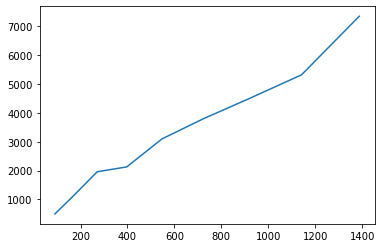

In [250]:
from matplotlib import pyplot as plt
plt.plot([91,169,271,397,547,721,919,1141,1387],[500,1120,1960,2130,3100,3790,4500,5320,7350])

In [18]:
import igl
import numpy as np
from src.elastic_energy import elastic_energy
import random

def MCstep_vertexB(ver,TRI,header,linklis,L,σ,r,k,β,H,c1,c2,A_v,normals_face,ADJ,NI,neighbour,et,ev,SHO,ver_bulk,border): #tries to move N vertices
    index=np.random.permutation(ver_bulk) #border vertices are fixed
    #count=0
    for i in index:
        #count+=1
        δ=np.array([random.uniform(-σ,σ),random.uniform(-σ,σ),random.uniform(-σ,σ)])
        x0=ver[i]
        cx,cy,cz= x0[0] // 1, x0[1] // 1, x0[2] // 1 #keep track of starting cell of x0
        x0+=δ #shift vertex
        boole=0
        for j in neighbour[i]:#For the neighbours check also that thether distance don't exeed max of sqrt(2)
            d=np.linalg.norm(x0-ver[j])
            if d < r or d > np.sqrt(2):
                x0-=δ #if neighbours too far put back vertex and break cycle
                boole=1 
                break
        if boole==0:
            cix,ciy,ciz= x0[0] // 1, x0[1] // 1, x0[2] // 1 #cell corresponding to new position
            cell_neig=[]
            for dx in range(-1,2): #also (0,0,0) so also checks that no overlap with particles contained in cell corresponding
                for dy in range(-1,2): #to new position
                    for dz in range(-1,2):
                        nx,ny,nz=int(cix+dx),int(ciy+dy),int(ciz+dz)
                        n=int(nx*L[1]*L[2]+ny*L[2]+nz)
                        z=header[n]
                        while(z!=-1):
                            if z not in neighbour[i]:#already checked no overlap with mesh neig
                                cell_neig.append(z)
                            z=int(linklis[z])
                            
            for c in cell_neig: #Check no overlaps with particles contained in neig cells
                d=np.linalg.norm(x0-ver[c])
                if d < r and d!=0: 
                    x0-=δ    #two  vertices overlap. Put back the vertex in it's original position
                    boole=1
                    break
            if boole==0:
                H_new, Av_new, Nf_old, N_v,c1_new,c2_new,SH_old,ind=update_energy_vertex(ver,TRI,H,c1,c2,k,A_v,i,normals_face,neighbour,ADJ,NI,area,SHO,et)
                H_new,Avj,SH_old_neig,ind_neig,c1_neig,c2_neig,ind_c=update_energy_neig(ver,TRI,H_new,c1,c2,k,A_v,i,normals_face,neighbour,ADJ,NI,area,SHO,et,border)
                H_new=H_new.real
                #print(H," ",H_new)
                ΔH=H_new-H
                P=min(1, np.exp(-β* ΔH))
                if np.random.rand()>P: #with probability 1-P put vertex back
                    x0-=δ
                    for u in range(0,len(Nf_old)): #Put back also normals of faces and face areas
                        area[Nf_old[u][2]]=Nf_old[u][1]
                        normals_face[Nf_old[u][2]]=Nf_old[u][0]
                    for v in range(0,len(ind)):   #Put back shape operators 
                        edge=ev[ind[v][0]]
                        SHO[:,:,ind[v][0],ind[v][1]]=SH_old[:,:,v]
                        for g in range(0,len(edge)): #update also shape shape operator centered in opposite vertex if not border
                            if edge[g]!=ind[v][1]:
                                if border[edge[g]]==False:
                                    SHO[:,:,ind[v][0],edge[g]]=-SH_old[:,:,v]
                    for w in range(0,len(ind_neig)): #already updates shape op centered in both vertices if not neig
                        SHO[:,:,ind_neig[w][0],ind_neig[w][1]]=SH_old_neig[:,:,w]
                    
                else: #particle shifted, update cell list linked list
                    c=int(cx*L[1]*L[2]+cy*L[2]+cz) #linear index that containined x0,that has now been shifted
                    ci=int(cix*L[1]*L[2]+ciy*L[2]+ciz) #new linear index of cell containing x0
                    if c!=ci: #shift particle only if it changes cell
                        if header[c]==i: #if header of starting cell was x0
                            header[c]=linklis[i]  #update header of cell where removing x0, new header particle to which x0
                        else:                     #pointed (-1 if none)
                            z=header[c]
                            #print(i)
                            while(z!=i): #find particle that pointed to i
                                q=z
                                z=int(linklis[z])
                                #print(q,z)
                            linklis[q]=linklis[i] #removing x0 particle that pointed to x0 points to particle that was pointed 
                                                  #by x0
                        if header[ci]==-1: #updates for new cell containing x0, if empty x0 now points to empty and becomes new 
                                           #header
                            linklis[i]=-1
                            header[ci]=i
                        else: #if particle already present, x0 points to previous header and becomes new header
                            linklis[i]=header[ci]
                            header[ci]=i
                    #update also A_v, curvatures at vertex,energy
                    A_v[i]=Av_new #new area at vertex 
                    for u in range(0,len(Avj)): #new neighbours area
                        A_v[Avj[u][1]]=Avj[u][0]
                        c1[ind_c[u]]=c1_neig[u] #new neig curvatures
                        c2[ind_c[u]]=c2_neig[u]
                    c1[i]=c1_new; c2[i]=c2_new
                    H=H_new
    return H    
    

In [19]:
def update_energy_neig(ver,TRI,H_old,c1,c2,k,A_v,i,normals_face,neigh,ADJ,NI,area,SHO,et,border): #to be used after update energy vertex,uses already updated lists of face normals and areas
    H_new=H_old
    Avj=[]
    SH_old_neig=np.zeros([3,3,2*len(neigh[i])])
    c1_neig=[]; c2_neig=[]
    ind_c=[]
    ind_neig=[]
    count=0
    for j in neigh[i]: #Calculate new normals and vertex areas
        if border[j]==False: #new curvature of j only if not border vertex 
            N_v=0; Av=0
            SH_old=np.zeros([3,3,len(neigh[i])]) #Shape operators of old edges
            ind=[] #corresponding indices
            neig_faces_j=ADJ[NI[j]:NI[j+1]]
            for m in neig_faces_j:
                Nf=normals_face[m]
                Af=area[m]
                N_v+=Nf*Af
                Av+=Af
            N_v=N_v/np.linalg.norm(N_v)
            Av=Av/3
            Avj.append([Av,j])
            S_v=np.zeros([3,3])
            for z in neigh[j]: #Calculate new curvatures
                neig_faces_z=ADJ[NI[z]:NI[z+1]]
                faces=[]
                for q in neig_faces_z:
                    if q in neig_faces_j:
                        faces.append(q)
                Nf_1=normals_face[faces[0]]
                Nf_2=normals_face[faces[1]]
                et1=et[faces[0]]; et2=et[faces[1]] #list of edges used by faces considered
                e=0
                for l in et1:
                    if l in et2:
                        e=l #index of edge on which calculating curvature

                N_e=(Nf_1+Nf_2) #new edge normal
                N_e=N_e/np.linalg.norm(N_e)
                #print(S_e,e,j)
                P_v=np.identity(3)-np.tensordot(N_v,N_v,axes=0)
                W_e=np.dot(N_v,N_e)
                if z in neigh[i]: #calculate new shape operator for edges neigh triangles that changed face normal
                    SH_old_neig[:,:,count]=np.copy(SHO[:,:,e,j]) #store old shape op
                    ind_neig.append([e,j]) #edge e centered in vertex i
                    count+=1
                    r_e=ver[z]- ver[j]
                    ϕ=np.sign(np.dot(np.cross(Nf_1,Nf_2),r_e))*np.arccos(np.dot(Nf_1,Nf_2))+np.pi
                    #now can find edge curvature
                    h=2*np.linalg.norm(r_e)*np.cos(0.5*ϕ)
                    R_e=r_e/np.linalg.norm(r_e)
                    b=np.cross(R_e,N_e)
                    S_e=h*np.tensordot(b,b,axes=0) #Shape operatordot() 
                    SHO[:,:,e,j]=S_e #update shape operator related to edge e centered in i
                    #SHO[:,:,e,z]=-S_e #update shape operator related to edge e centered in i

                else:
                    S_e=SHO[:,:,e,j] #extract shape operator corresponding to edge considered (edges neigh shifted vertex already updated in vertex)
                S_v+=W_e*np.dot((np.conjugate(P_v.transpose())),np.dot(S_e,P_v))

            S_v=S_v/Av #vertex shape operator has one zero eigenvalue and the other two are the curvatures
            #print(np.dot(S_v,N_v))

            #Householder transformation

            x=[0,0,1] #start from canonical reference frame
            pvec=x+N_v
            mvec=x-N_v
            if np.linalg.norm(pvec)>np.linalg.norm(mvec):
                pvec=pvec/np.linalg.norm(pvec)
                T_H=(np.identity(3)-2*np.tensordot(pvec,pvec,axes=0))
            else:
                mvec=mvec/np.linalg.norm(mvec)
                T_H=(np.identity(3)-2*np.tensordot(mvec,mvec,axes=0))

            C_v=np.dot((np.conjugate(T_H.transpose())),np.dot(S_v,T_H)) #now C 2x2 minor with nonzero elements
            p=C_v[0,0]; q=C_v[0,1]
            r=C_v[1,0]; s=C_v[1,1]
            if q!=0 and r!=0:
                insq=(p+s)**2-4*(p*s-q*r) #value of which will take squared root

                if insq>0: #avoid complex eigenvalues
                    c1_new=((p+s)+np.sqrt(insq))*0.5  #largest eigenvalue                            
                    c2_new=((p+s)-np.sqrt(insq))*0.5  #smallest
                else: #degenerate eigenvalues
                    c1_new=(p+s)*0.5                               
                    c2_new=e1
            else:
                if p>s:
                    c1_new=p
                    c2_new=s
                else:
                    c1_new=s
                    c2_new=p




            if abs(c1_new)<=10e-10:
                c1_new=0
            if abs(c2_new)<=10e-10:
                c2_new=0
            c1_neig.append(c1_new)
            c2_neig.append(c2_new)
            ind_c.append(j)
            H_new=H_new+(((c1_new+c2_new)**2)*Av*0.5*k)-(((c1[j]+c2[j])**2)*A_v[j]*0.5*k)
        #print(H_new)
    return H_new,Avj,SH_old_neig,ind_neig,c1_neig,c2_neig,ind_c

        
            
        

In [185]:
%timeit update_energy_neig(ver,TRI,H_elast,c1,c2,k,A_v,0,normals_face,neigh,ADJ,NI,area,SHO,et)

6.37 ms ± 374 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
def update_energy_vertex(ver,TRI,H_old,c1,c2,k,A_v,i,normals_face,neigh,ADJ,NI,area,SHO,et):
    #aus=H_old-(((c1[i]+c2[i])**2)*A_v[i]*0.5*k)
    N_v=np.zeros(3)
    Nf_old=[] #list with old face normals, areas and associated indices
    Av_new=0
    neig_faces_i=ADJ[NI[i]:NI[i+1]]
    SH_old=np.zeros([3,3,len(neigh[i])]) #Shape operators of old edges
    ind=[] #corresponding indices
    for m in neig_faces_i: #calculate new vertex area, new face normals, new vertex normal
        x,y,z=ver[TRI[m][0]],ver[TRI[m][1]],ver[TRI[m][2]]
        α=x-y; β=x-z
        A_face=0.5*np.linalg.norm(np.cross(α,β)) #area of j-th neig face
        Nf=np.cross(α,β)/np.linalg.norm(np.cross(α,β)) #new normal of j-th neig face
        Nf_old.append([np.copy(normals_face[m]),area[m],m])
        N_v+=Nf*A_face
        Av_new+=A_face
        area[m]=A_face #update lists, then in MCvertex will put back old ones if vertex was put back
        normals_face[m]=Nf
        
    N_v=N_v/np.linalg.norm(N_v)
    Av_new=Av_new/3
    count=0
    S_v=np.zeros([3,3])
    for j in neigh[i]: #calculate new energy contribution of shifted vertex
        r_e=ver[j]- ver[i] #vector connecting central vertex to adjacent ones
        #to find faces that share edge connecting i,j without searching ev
        neig_faces_j=ADJ[NI[j]:NI[j+1]]
        faces=[]
        for q in neig_faces_i:
            if q in neig_faces_j:
                faces.append(q)
        Nf_1=normals_face[faces[0]]
        Nf_2=normals_face[faces[1]]
        et1=et[faces[0]]; et2=et[faces[1]] #list of edges used by faces considered
        e=0
        for z in et1:
            if z in et2:
                e=z #index of edge on which calculating curvature
        SH_old[:,:,count]=np.copy(SHO[:,:,e,i]) #store old shape op
        ind.append([e,i]) #edge e centered in vertex i
        count+=1
                
        ϕ=np.sign(np.dot(np.cross(Nf_1,Nf_2),r_e))*np.arccos(np.dot(Nf_1,Nf_2))+np.pi
        #now can find edge curvature
        h=2*np.linalg.norm(r_e)*np.cos(0.5*ϕ)
        #To calculate shape operator calculate first edge normal using face normals
        N_e=(Nf_1+Nf_2)
        N_e=N_e/np.linalg.norm(N_e)
        #Shape operator on edge e
        R_e=r_e/np.linalg.norm(r_e)
        b=np.cross(R_e,N_e)
        S_e=h*np.tensordot(b,b,axes=0) #Shape operatordot()
        SHO[:,:,e,i]=S_e #update shape operator related to edge e centered in i
        if border[j]==False:
            SHO[:,:,e,j]=-S_e #update also the shape operator related to same edge an centered in opposite vertex
        P_v=np.identity(3)-np.tensordot(N_v,N_v,axes=0) #Projection operator
        #Project shape operator on edge and obtain shape operator at vertex
        #print(N_v," ",N_e)
        #print(np.dot(N_e,N_v))
        W_e=np.dot(N_v,N_e)
        S_v+=W_e*np.dot((np.conjugate(P_v.transpose())),np.dot(S_e,P_v))

        
    S_v=S_v/Av_new #vertex shape operator has one zero eigenvalue and the other two are the curvatures
    
    
    #Householder transformation
    x=[0,0,1] #start from canonical reference frame
    pvec=x+N_v
    mvec=x-N_v
    if np.linalg.norm(pvec)>np.linalg.norm(mvec):
        pvec=pvec/np.linalg.norm(pvec)
        T_H=(np.identity(3)-2*np.tensordot(pvec,pvec,axes=0))
    else:
        mvec=mvec/np.linalg.norm(mvec)
        T_H=(np.identity(3)-2*np.tensordot(mvec,mvec,axes=0))

    C_v=np.dot((np.conjugate(T_H.transpose())),np.dot(S_v,T_H)) #now C 2x2 minor with nonzero elements
    p=C_v[0,0]; q=C_v[0,1]
    r=C_v[1,0]; s=C_v[1,1]
    if q!=0 and r!=0:
        insq=(p+s)**2-4*(p*s-q*r) #value of which will take squared root

        if insq>0: #avoid complex eigenvalues
            c1_new=((p+s)+np.sqrt(insq))*0.5  #largest eigenvalue                            
            c2_new=((p+s)-np.sqrt(insq))*0.5  #smallest
        else: #degenerate eigenvalues
            c1_new=(p+s)*0.5                               
            c2_new=e1
    else:
        if p>s:
            c1_new=p
            c2_new=s
        else:
            c1_new=s
            c2_new=p

    if abs(c1_new)<=10e-10:
        c1_new=0
    if abs(c2_new)<=10e-10:
        c2_new=0

    H_new=H_old+(((c1_new+c2_new)**2)*Av_new*0.5*k)-(((c1[i]+c2[i])**2)*A_v[i]*0.5*k)

    return H_new, Av_new, Nf_old, N_v,c1_new,c2_new,SH_old,ind

    
    
    
        
        
    
    

In [509]:
%timeit update_energy_vertex(ver,TRI,H_elast,c1,c2,k,A_v,0,normals_face,neigh,ADJ,NI,area,SHO,et)

3.85 ms ± 183 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [699]:
i=0
k=1
normals_ver=igl.per_vertex_normals(ver, TRI, igl.PER_VERTEX_NORMALS_WEIGHTING_TYPE_AREA)
z=np.array([1/3,1/3,1/3])
z=z/np.linalg.norm(z)
normals_face=igl.per_face_normals(ver,TRI,z) #z normal given to degenerate faces(??)
area = igl.doublearea(ver, TRI) / 2.0
neigh=igl.adjacency_list(TRI)
ADJ,NI=igl.vertex_triangle_adjacency(TRI, len(ver))
border=igl.is_border_vertex(ver,TRI)

H_elast,c1,c2,A_v,SHO2=Elastic_Local(ver,TRI,k,normals_ver,normals_face,area,neigh,ADJ,NI,et,te,border)

In [692]:
δ=np.array([random.uniform(-σ,σ),random.uniform(-σ,σ),random.uniform(-σ,σ)])
H=H_elast
fert=[0]
for i in ver_bulk[0:1]:
    ver[i]+=δ
    H_new, Av_new, Nf_old, N_v,c1_new,c2_new,SH_old,ind=update_energy_vertex(ver,TRI,H,c1,c2,k,A_v,i,normals_face,neigh,ADJ,NI,area,SHO,et)

    H_new,Avj,SH_old_neig,ind_neig,c1_neig,c2_neig,ind_c=update_energy_neig(ver,TRI,H_new,c1,c2,k,A_v,i,normals_face,neigh,ADJ,NI,area,SHO,et,border)
    A_v[i]=Av_new #new area at vertex 
    for u in range(0,len(Avj)): #new neighbours area
        A_v[Avj[u][1]]=Avj[u][0]
        c1[ind_c[u]]=c1_neig[u] #new neig curvatures
        c2[ind_c[u]]=c2_neig[u]
    c1[i]=c1_new; c2[i]=c2_new
    H=H_new


In [524]:
H_new, A_v[0], c1[0],c2[0]

(26.962217644595256,
 1.1901759992174286,
 1.1921735952077541,
 0.030968425814434042)

# Elastic Energy
Idea to calculate curvature on each edges, in a discrete surface there is a change in curvature only when a edge is crossed. Calculate curvature on each edge as:
\begin{equation}
h(e)=2|\vec{r_{e}}|cos(\frac{\phi(e)}{2})
\end{equation}
with $\vec{r_{e}}=\vec{x_1}-\vec{x_2}$ vector along the edge and $\phi(e)$ signed dihedral angle given by:
\begin{equation}
\phi(e)=sign(\hat{N}(f,1) \times \hat{N}(f,2) \cdot \vec{r}_e)arccos(\hat{N}(f,1) \cdot \hat{N}(f,2))+\pi
\end{equation}.


In [48]:
normals_ver=igl.per_vertex_normals(ver, TRI, igl.PER_VERTEX_NORMALS_WEIGHTING_TYPE_AREA)
z=np.array([1/3,1/3,1/3])
z=z/np.linalg.norm(z)
normals_face=igl.per_face_normals(ver,TRI,z) #z normal given to degenerate faces(??)
area = igl.doublearea(ver, TRI) / 2.0
neigh=igl.adjacency_list(TRI)
ADJ,NI=igl.vertex_triangle_adjacency(TRI, len(ver))
border=igl.is_border_vertex(ver,TRI)


def Elastic_Local(ver,TRI,k,normals_ver,normals_face,area,neigh,ADJ,NI,et,te,border):
    aus=0
    curv_E=[]
    f1=[]; f2=[]; eigenv=[]
    SHO=np.zeros([3,3,len(te),len(ver)]) #matrix that store shape operator at each edge
    A_v=np.zeros(len(ver))
    for i in range(0,len(ver)): #calculate curvature at each vertex
        if border[i]==True:
            f1.append(0.0); f2.append(0.0) #zero curvature at border vertices
        else:
            #Calculate Area associated to each vertex for later use
            neig_faces_i=ADJ[NI[i]:NI[i+1]] #faces neighbouring vertex i
            for m in neig_faces_i:
                A_v[i]+=area[m]
            A_v[i]=A_v[i]/3
            N_v=normals_ver[i]#Normal to vertex
            S_v=np.zeros([3,3])
            for j in neigh[i]:
                r_e=ver[j]- ver[i] #vector connecting central vertex to adjacent ones
                #to find faces that share edge connecting i,j without searching ev
                neig_faces_j=ADJ[NI[j]:NI[j+1]]
                faces=[]
                for q in neig_faces_i:
                    if q in neig_faces_j:
                        faces.append(q)
                Nf_1=normals_face[faces[0]]
                Nf_2=normals_face[faces[1]]
                et1=et[faces[0]]; et2=et[faces[1]] #list of edges used by faces considered
                e=0
                for z in et1:
                    if z in et2:
                        e=z #index of edge on which calculating curvature

                #find signed dihedral angle
                ϕ=np.sign(np.dot(np.cross(Nf_1,Nf_2),r_e))*np.arccos(np.dot(Nf_1,Nf_2))+np.pi
                #now can find edge curvature
                h=2*np.linalg.norm(r_e)*np.cos(0.5*ϕ)
                print(h)
                #To calculate shape operator calculate first edge normal using face normals
                N_e=(Nf_1+Nf_2)
                N_e=N_e/np.linalg.norm(N_e)
                #Shape operator on edge e
                R_e=r_e/np.linalg.norm(r_e)
                b=np.cross(R_e,N_e)
                b=b/np.linalg.norm(b)
                S_e=h*np.tensordot(b,b,axes=0) #Shape operator
                SHO[:,:,e,i]=S_e #Save shape operator in position corresponding to edge, shape operator changes sign with directed edge, also index, shape operator centered in index i
                P_v=np.identity(3)-np.tensordot(N_v,N_v,axes=0) #Projection operator
                #Project shape operator on edge and obtain shape operator at vertex
                #print(N_v," ",N_e)
                #print(np.dot(N_e,N_v))
                W_e=np.dot(N_v,N_e)
                S_v+=W_e*np.dot((np.conjugate(P_v.transpose())),np.dot(S_e,P_v))


            S_v=S_v/A_v[i] #vertex shape operator has one zero eigenvalue and the other two are the curvatures
            #print(np.dot(S_v,N_v))# N_v IS eigenvector with zero eigenvalue
            
            #Householder transformation
            x=[0,0,1] #start from canonical reference frame
            pvec=x+N_v
            mvec=x-N_v
            if np.linalg.norm(pvec)>np.linalg.norm(mvec):
                pvec=pvec/np.linalg.norm(pvec)
                T_H=(np.identity(3)-2*np.tensordot(pvec,pvec,axes=0))
            else:
                mvec=mvec/np.linalg.norm(mvec)
                T_H=(np.identity(3)-2*np.tensordot(mvec,mvec,axes=0))

            C_v=np.dot((np.conjugate(T_H.transpose())),np.dot(S_v,T_H)) #now C 2x2 minor with nonzero elements
            p=C_v[0,0]; q=C_v[0,1]
            r=C_v[1,0]; s=C_v[1,1]
            if q!=0 and r!=0:
                insq=(p+s)**2-4*(p*s-q*r) #value of which will take squared root

                if insq>0: #avoid complex eigenvalues
                    c1=((p+s)+np.sqrt(insq))*0.5  #largest eigenvalue                            
                    c2=((p+s)-np.sqrt(insq))*0.5  #smallest
                else: #degenerate eigenvalues
                    c1=(p+s)*0.5                               
                    c2=c1
            else:
                if p>s:
                    c1=p
                    c2=s
                else:
                    c1=s
                    c2=p

                    
            if abs(c1)<=10e-10:
                c1=0
            if abs(c2)<=10e-10:
                c2=0
            f1.append(c1)
            f2.append(c2)
            aus+=((c1+c2)**2)*A_v[i]*0.5*k
            #curv_E.append(((c1+c2)**2)*A_v[i]*0.5*k)

    
    H_elastic=aus
    return H_elastic,f1,f2,A_v,SHO


In [49]:
H_elastic,c1,c2,A_v,SHO=Elastic_Local(ver,TRI,k,normals_ver,normals_face,area,neigh,ADJ,NI,et,te,border)

-1.076375647592839
1.07637564759284
-1.076375647592839
1.07637564759284
1.0763756475928394
1.0763756475928394


In [47]:
c1[1],c2[1]

(1.5727391874181014, -0.5242463958060332)